In [1]:
import os
DATASETS_PATH = os.path.join(os.path.expanduser('~/Projects/UpgradDemos/Datasets'))
IMAGES_PATH = os.path.join(os.path.expanduser('~/Projects/UpgradDemos/Images'))
CHECKPOINTS_PATH = os.path.join(os.path.expanduser('~/Projects/UpgradDemos/Checkpoints'))
from ipynb.fs.defs.lime_base import Lime, LimeHyperparameters, LimeData, xProbClassificationModel
from tqdm import tqdm

# from google.colab import drive
# drive.mount('/content/gdrive')
# IMAGES_PATH = os.path.join('/content/gdrive/My Drive/',
#                            'Documents/IIITB/Courses/Upgrad/xAI/images')

# Lime on a Text Classifier --- Sentiment Analysis

## Using a pretrained Falir model for Sentiment Analysis

In [2]:
import csv
import numpy as np
from numpy import ndarray as Array
from typing import Any, Tuple, List
import math

## Create the custom Lime data and model classes for text

In [ ]:
import flair
from flair.models import TextClassifier
from flair.data import Sentence

class FlairTextPreprocessor:
    POS, NEG = 'POSITIVE', 'NEGATIVE'
    SENTIMENT_VALUES = {POS: 1, NEG: 0}
    SENTIMENT_LABELS = {0: NEG, 1: POS}
    BIG_CONST = 100
    def __init__(self,
                 dataset_name:str,
                 size_to_load:int=None):
        self.sentences, self.token_lists, self.tokens, self.labels = self.load_tokenize_dataset(dataset_name, size_to_load)
        self.token_map = {i: t for t, i in self.tokens.items()}
        self.max_sentence_length = max([len(s) for s in self.sentences])
        print(f'Preprocessing Dataset {dataset_name}')
        print(f'N Sentences: {self.n_sentences}; N Tokens: {self.n_tokens}')
        print(f'Max Sentence Length: {self.max_sentence_length}')

    @property
    def dummy_id(self):
        return math.ceil(len(self.token_lists)/self.BIG_CONST) * self.BIG_CONST

    @property
    def max_token_id(self):
        return max(self.token_map.keys())

    @property
    def n_tokens(self):
        return len(self.tokens)
    
    @property
    def n_labels(self):
        return len(self.SENTIMENT_LABELS)

    @property
    def n_sentences(self):
        return len(self.sentences)

    def id(self,
           token:str):
        return self.tokens[token]

    def token(self,
              token_id:int):
        return self.token_map[token_id]

    def label(self,
              l:int):
        return self.SENTIMENT_LABELS[self.labels[l]]

    def load_tokenize_dataset(self,
                              dataset_name:str,
                              size_to_load:int=None):
        # Open the CSV file in read mode
        with open(os.path.join(DATASETS_PATH, f'{dataset_name}.csv'), 'r', newline='') as csvfile:
            # Create a CSV reader object
            # The 'newline=' argument prevents extra blank rows when reading CSV files
            csv_reader = csv.reader(csvfile)
            # Ignore the first (header) row
            next(csv_reader)

            sentences, token_lists, tokens, labels = [], [], {}, []
            # Iterate over each row in the CSV file
            token_id = 1 # 0 is reserved for dummy token
            for review, label in tqdm(csv_reader, desc='Tokenizing dataset ...'):
                sentence = Sentence(review, use_tokenizer=False)
                sentences.append(sentence)
                labels.append(self.SENTIMENT_VALUES[label.upper()])
                for token in sentence:
                    if token.text not in tokens:
                        tokens[token.text] = token_id
                        token_id += 1
                token_lists.append([tokens[token.text] for token in sentence])
                if size_to_load is not None and len(sentences) >= size_to_load:
                    break
        return sentences, token_lists, tokens, labels


class TextLimeData(LimeData):
    def __init__(self,
                 preprocessor:FlairTextPreprocessor,
                 n_for_explanation:int,
                 hp:LimeHyperparameters):
        self.preprocessor = preprocessor
        token_array = np.array([(s + ([preprocessor.dummy_id] * (preprocessor.max_sentence_length - len(s))))
                                for s in self.preprocessor.token_lists])
        self.sample_idxs = np.random.choice(token_array.shape[0], n_for_explanation, replace=False)
        token_array = token_array[self.sample_idxs]
        super().__init__(token_array, hp)
        print()
        print('Reviews for explanation:')
        for i in self.sample_idxs:
            print(self.preprocessor.label(i), self.preprocessor.sentences[i])
        
        self.targets = np.array([self.preprocessor.labels[i] for i in self.sample_idxs])

    @property
    def max_token_id(self):
        return self.preprocessor.max_token_id

    def gen_xp_representations_(self) -> Array:
        """The xp-representation we are using is just a 0-1 array for each sentence
        to indicate the presence or absence of a taken at that position w.r.t to the
        original sentence.
        """
        # Replace all valid tokens by 1 and dummy tokens by 0
        return np.where(self.x == self.preprocessor.dummy_id, 0, 1)

    def xp_labels_(self,
                   d:int,
                   idxs)-> Tuple[str]:
        """Labels associated with a given set (as an array of feature indexes) of xp-features for a given datapoint 
        with index 'i' --- this is accommodate cases where the labels are different for different datapoints"""
        datapoint_id = self.sample_idxs[d]
        datapoint_tokens = self.preprocessor.token_lists[datapoint_id]
        # Get the tokens at the given indexes"""
        return tuple([self.preprocessor.token_map[datapoint_tokens[i]] for i in idxs if i < len(datapoint_tokens)])

    def gen_local_samples_(self,
                           z:Array) -> Array:
        """Randomly replace some of the 1's in the xp-representation with 0's
        This is equivalent to removing some of the words from the sentence at random
        """
        n_features = z.shape[1]
        random_ones = np.random.choice(a=[0,1], p=[(1 - self.hp.alpha), self.hp.alpha],
                                       size=(self.n, self.hp.n_local_samples, n_features))
        # Replace the 1's in z with random choices
        return z[:, np.newaxis, :] * random_ones

    def remove_padding_(self,
                        d:int,
                        samples:Array) -> Array:
        """Remove padding if any that was added for the d-th datapoint
        By default we don't do anything"""
        # Find the number of tokens in the d-th datapoint
        d_width = len(self.preprocessor.token_lists[d])
        # Truncate samples to the width of the d-th datapoint
        samples = samples[:, :d_width]
        return samples

    def reverse_map_(self) -> Array:
        """Find the points in the inp-space for every point in 'z' in the xp-space"""
        # Replace the 1's in the xp-representation with the actual token ids at those positions
        return self.xp_local * self.x[:, np.newaxis, :]

    def diff_(self, x:Array, y:Array) -> Array:
        """Implementing the Hamming distance"""
        return np.where((x - y) != 0, 1, 0)

/home/raghavan/InstalledSW/anaconda3/envs/dl25/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raghavan/InstalledSW/anaconda3/envs/dl25/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/libtorch_1745854776362/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
class TextLimeModel(xProbClassificationModel):
    def __init__(self,
                 preprocessor:FlairTextPreprocessor,
                 model:Any):
        super().__init__(model, (preprocessor.max_sentence_length,), (preprocessor.n_labels,))
        self.preprocessor = preprocessor

    def decision(self, score:float):
        return 1 if score > 0 else 0

    def sign(self, decision:str):
        return -1 if decision == self.preprocessor.NEG else 1

    def prob_pair(self, score:float, value:str):
        signed_score = self.sign(value) * score
        p = (signed_score + 1) / 2
        return ((1 - p), p)

    def predict_(self,
                x:Array) -> Array:
        """x is an array of token_ids"""
        # Convert x into sentences
        sentences = [Sentence(' '.join([self.preprocessor.token_map[t] for t in s if t != 0]))
                     for s in x.tolist()]
        self.model.predict(sentences)
        # Get the predictions
        return np.array([self.prob_pair(s.labels[0].score, s.labels[0].value) for s in sentences])

    def decisions_(self,
                   predictions:Array) -> Tuple[Array, Tuple]:
        d, labels = super().decisions_(predictions)
        return d, tuple([self.preprocessor.label(int(i)) for i in d.tolist()])

Tokenizing dataset ...: 4999it [00:04, 1247.65it/s]


Preprocessing Dataset imdb_reviews
N Sentences: 5000; N Tokens: 101664
Max Sentence Length: 1737
5 Points for explanation with (1737,) features each

Reviews for explanation:
POSITIVE Sentence[157]: "There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (the

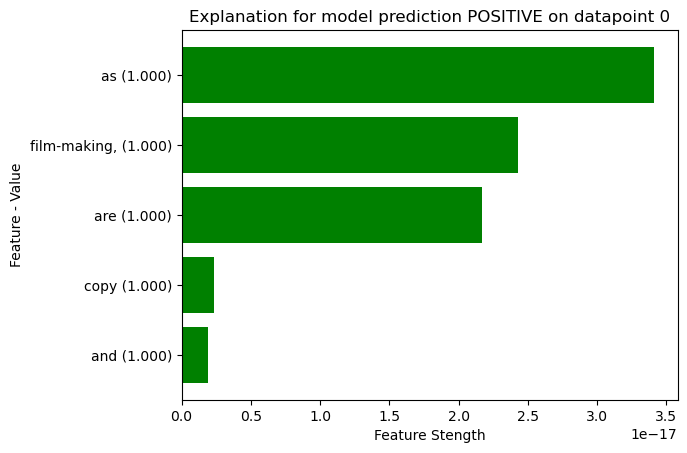


Explaining Model Prediction POSITIVE for datapoint 2
Samples shape after removing padding: (101, 162)
367
Generating the sparse local model
[ 2 11 21 45 68]
5
('I', 'came', 'away', 'from', 'this', 'movie', 'with', 'the', 'feeling', 'that', 'it', 'could', 'have', 'been', 'so', 'much', 'better.', 'Instead', 'of', 'what', 'should', 'be', 'a', 'gripping,', 'tense', 'story', 'of', 'a', "boy's", 'fight', 'for', 'survival', 'in', 'the', 'wilderness,', 'it', 'comes', 'off', 'as', 'a', 'National', 'Geographic', 'documentary', 'meets', 'Columbia', 'sportswear', 'ad.<br', '/><br', '/>The', 'film', 'begins', 'with', 'Brian', '(Jared', 'Rushton)', 'preparing', 'for', 'a', 'journey', 'by', 'plane', 'to', 'see', 'his', 'father.', 'His', 'mother', 'fortuitously', 'gives', 'him', 'the', 'curious', 'choice', 'of', 'a', 'hatchet', 'as', 'a', 'going-away', 'gift', "(what's", 'wrong', 'with', 'a', "Rubik's", 'Cube?),', 'little', 'knowing', 'how', 'badly', 'he', 'will', 'soon', 'need', 'it.', 'Once', 'in',

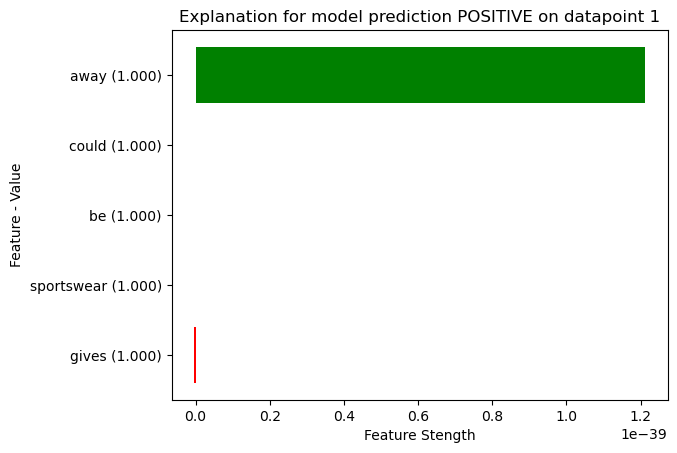


Explaining Model Prediction POSITIVE for datapoint 3
Samples shape after removing padding: (101, 166)
459
Generating the sparse local model
[ 22  66  99 120 149]
5
("I've", 'heard', 'a', 'few', 'comments,', 'particularly', 'from', 'prisoners', 'of', 'war,', 'that', 'CHANGI', 'is', 'not', 'historically', 'accurate,', 'and', 'that', 'it', 'is', 'disappointing.', 'Perhaps', 'it', 'is', 'for', 'those', 'who', 'actually', 'had', 'to', 'live', 'through', 'this', 'stuff,', 'and', 'much', 'worse.', 'But', 'for', 'the', 'rest', 'of', 'us,', 'who', 'really', 'have', 'no', 'idea', 'of', 'how', 'prisoners', 'were', 'treated', 'by', 'the', 'Japanese', 'during', 'World', 'War', 'II,', 'CHANGI', 'is', 'a', 'remarkable', 'introduction.', 'But', 'CHANGI', "isn't", 'a', 'war', 'documentary', '-', 'if', 'it', 'had', 'have', 'been,', 'then', 'the', 'historical', 'accuracy', 'aspect', 'would', 'have', 'been', 'paramount.', 'It', 'is', 'a', 'miniseries', 'drama,', 'with', 'fictional', 'characters', 'and', 

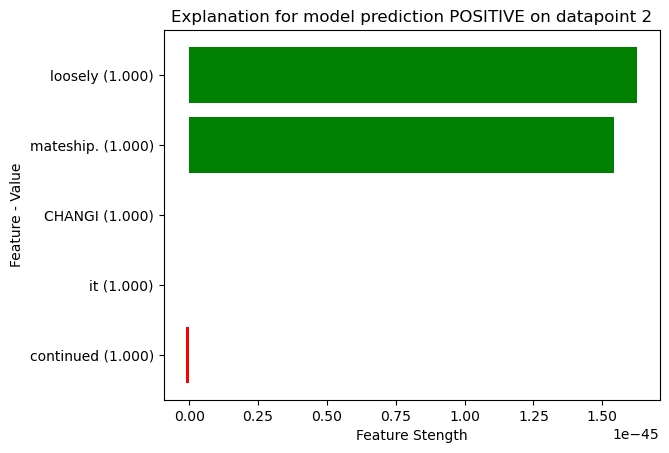


Explaining Model Prediction POSITIVE for datapoint 4
Samples shape after removing padding: (101, 138)
456
Generating the sparse local model
[  3  22  89  98 130]
5
('A', 'convict', 'serving', 'time', 'comes', 'forward', 'to', 'give', 'the', 'Cold', 'Case', 'unit', 'information', 'about', 'the', 'murder', 'of', 'a', 'policeman,', 'committed', 'years', 'before.', 'The', 'murder', 'of', 'Sean', 'Cooper,', 'a', 'good', 'cop,', 'was', 'never', 'solved.', 'Naturally,', 'the', 'detectives', 'believe', 'the', 'new', 'evidence', 'will', 'help', 'them', 'put', 'together', 'all', 'the', 'pieces', 'of', 'the', 'puzzle', 'that', 'frustrated', 'their', 'colleagues.<br', '/><br', '/>In', 'flashbacks', 'we', 'are', 'taken', 'to', 'the', 'baptism', 'of', 'James', "Bruno's", 'baby.', 'Sean', 'and', 'Jimmy', 'were', 'partners.', 'There', 'is', 'tension', 'as', 'Sean,', 'who', 'is', 'the', 'godfather,', 'arrives', 'disheveled', 'and', 'late', 'for', 'the', 'rite.', 'Eileen', 'Bruno', "doesn't", 'appear',

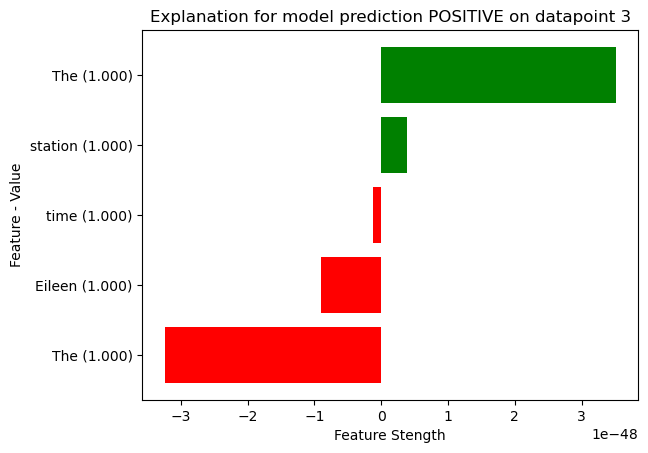


Explaining Model Prediction POSITIVE for datapoint 5
Samples shape after removing padding: (101, 230)
118
Generating the sparse local model
[ 5 18 44 73 99]
5
('I', 'have', 'seen', 'many', 'many', 'movies', 'and', 'this', 'just', 'totally', 'blew', 'my', 'mind.', 'The', 'trauma,', 'the', 'suspense', 'is', 'just', 'amazing.', 'I', 'ended', 'so', 'wound', 'up', 'in', 'the', 'psychological', 'fear', 'and', 'Philosophy', 'of', 'it,', 'and', 'relating', 'it', 'to', 'reality.', 'Movies', 'that', 'play', 'and', 'challenge', 'your', 'mind', 'are', 'movies', 'you', "don't", 'forget,', 'those', 'that', 'make', 'you', 'doubt', 'your', 'reality.', 'A', 'problem', 'could', 'be', 'the', 'quality,', 'but', 'that', "doesn't", 'bring', 'down', 'the', 'essence', 'of', 'the', 'movie.<br', '/><br', '/>The', 'idea', 'it', 'self', 'is', 'brilliant', 'and', 'the', 'ending', 'leaves', 'you', 'just', 'completely', 'shocked', 'and', 'with', 'the', 'question', 'for', 'you', 'to', 'seek', 'the', 'answer.', 'I', 

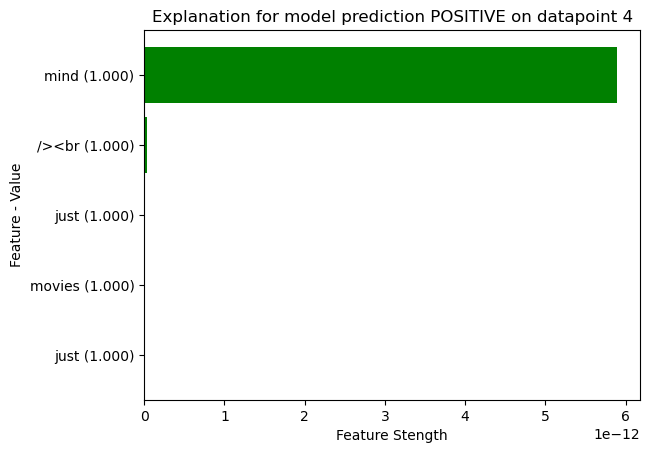

In [5]:
from sklearn.linear_model import Ridge


def lime_on_flair_classification_on_imdb_data(hp:LimeHyperparameters,
                                              preprocessor:FlairTextPreprocessor,
                                              n_for_explanation:int,
                                              explanation_model:Any):
    model = TextClassifier.load('en-sentiment')
    lmodel = TextLimeModel(preprocessor, model)
    ldata = TextLimeData(preprocessor, n_for_explanation, hp)
    model_decisions, decision_labels = lmodel.decisions_(lmodel.predict_(ldata.x))
    print()
    print(f'Model Decisions on the Loaded Data: {decision_labels}')
    # Using the default Ridge regression explanation model
    lime = Lime(hp, explanation_model)
    lime.explain(lmodel, ldata)

HP = LimeHyperparameters()
HP.alpha = 0.7
PREPROCESSOR = FlairTextPreprocessor('imdb_reviews', 5000)
EXPLANATION_MODEL = Ridge()
lime_on_flair_classification_on_imdb_data(HP, PREPROCESSOR, 5, EXPLANATION_MODEL)